Basic imports beforehand, we'll need seaborn for KDE lines later.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request


The data is pulled from the github for this project, available [here](https://github.com/silas-wunder/Data-Wrangling-Final-Project).

In [2]:
url = "https://github.com/silas-wunder/Data-Wrangling-Final-Project/blob/main/Chess_Data.pickle?raw=true"
with urllib.request.urlopen(url) as f:
    data = pd.read_pickle(f).astype(
        {
            "Game Type": "uint8",
            "Result": "uint8",
            "White ELO": "uint16",
            "Black ELO": "uint16",
            "Moves": "uint8",
        }
    )

data.replace(
    {
        "Game Type": {0: "Blitz", 1: "Bullet", 2: "Classical", 3: "Correspondence"},
        "Result": {0: "1-0", 1: "0-1", 2: "1/2-1/2"},
    },
    inplace=True,
)

data.drop(data.loc[data["White ELO"] == 0].index, inplace=True)
data.drop(data.loc[data["Black ELO"] == 0].index, inplace=True)
data.set_index(["Result", "Game Type"], inplace=True)
data.sort_index(inplace=True)


Our data came in looking like this:

```json
[Event "Rated Bullet tournament https://lichess.org/tournament/yc1WW2Ox"]
[Site "https://lichess.org/PpwPOZMq"]
[Date "2017.04.01"]
[Round "-"]
[White "Abbot"]
[Black "Costello"]
[Result "0-1"]
[UTCDate "2017.04.01"]
[UTCTime "11:32:01"]
[WhiteElo "2100"]
[BlackElo "2000"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+1"]
[WhiteTitle "FM"]
[ECO "B30"]
[Opening "Sicilian Defense: Old Sicilian"]
[TimeControl "300+0"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.17] [%clk 0:00:30] } 1... c5 { [%eval 0.19] [%clk 0:00:30] }
2. Nf3 { [%eval 0.25] [%clk 0:00:29] } 2... Nc6 { [%eval 0.33] [%clk 0:00:30] }
3. Bc4 { [%eval -0.13] [%clk 0:00:28] } 3... e6 { [%eval -0.04] [%clk 0:00:30] }
4. c3 { [%eval -0.4] [%clk 0:00:27] } 4... b5? { [%eval 1.18] [%clk 0:00:30] }
5. Bb3?! { [%eval 0.21] [%clk 0:00:26] } 5... c4 { [%eval 0.32] [%clk 0:00:29] }
6. Bc2 { [%eval 0.2] [%clk 0:00:25] } 6... a5 { [%eval 0.6] [%clk 0:00:29] }
7. d4 { [%eval 0.29] [%clk 0:00:23] } 7... cxd3 { [%eval 0.6] [%clk 0:00:27] }
8. Qxd3 { [%eval 0.12] [%clk 0:00:22] } 8... Nf6 { [%eval 0.52] [%clk 0:00:26] }
9. e5 { [%eval 0.39] [%clk 0:00:21] } 9... Nd5 { [%eval 0.45] [%clk 0:00:25] }
10. Bg5?! { [%eval -0.44] [%clk 0:00:18] } 10... Qc7 { [%eval -0.12] [%clk 0:00:23] }
11. Nbd2?? { [%eval -3.15] [%clk 0:00:14] } 11... h6 { [%eval -2.99] [%clk 0:00:23] }
12. Bh4 { [%eval -3.0] [%clk 0:00:11] } 12... Ba6? { [%eval -0.12] [%clk 0:00:23] }
13. b3?? { [%eval -4.14] [%clk 0:00:02] } 13... Nf4? { [%eval -2.73] [%clk 0:00:21] } 0-1
```


And after cleaning ([using this script](https://github.com/silas-wunder/Data-Wrangling-Final-Project/blob/main/data_cleaning.ipynb)), our data look like this:


In [3]:
data.head()


White ELO  Black ELO  Moves
Result Game Type                             
0-1    Blitz           1500       1537     50
       Blitz           1623       1651     60
       Blitz           1779       1771     49
       Blitz           1905       1789     48
       Blitz           1449       1395      9

ELO is a measure of a player's "skill", with a higher ELO denoting higher "skill." For example, the current World Champion Magnus Carelson has a max FIDE rating of 2865. There are multiple different ways of going about determining a player's ELO, but Lichess uses Glicko-2 ratings, more on that [here](https://en.wikipedia.org/wiki/Glicko_rating_system).


Let's begin by just visualizing all of our data stratified by the outcome of the game to get an idea of the general trends we might expect to see.

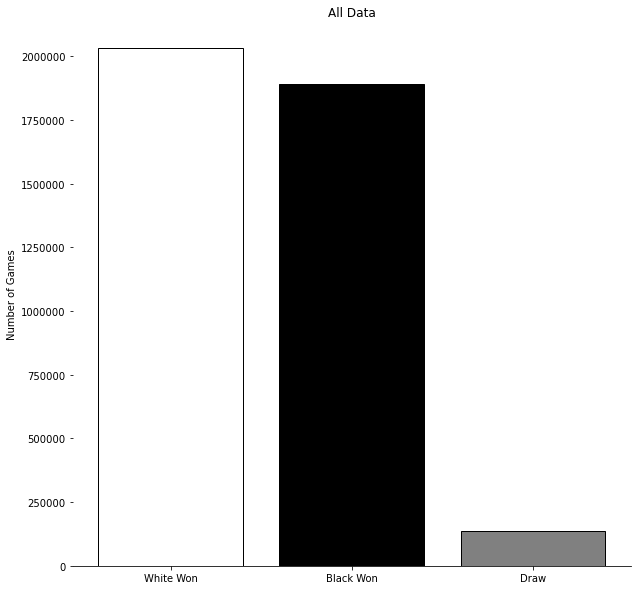

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.bar("White Won", len(data.loc["1-0"]), color="white", edgecolor="black")
ax.bar("Black Won", len(data.loc["0-1"]), color="black", edgecolor="black")
ax.bar("Draw", len(data.loc["1/2-1/2"]), color="gray", edgecolor="black")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_title("All Data")
ax.set_ylabel("Number of Games")
ax.ticklabel_format(style="plain", axis="y")


Following the majority of chess literature, white wins slightly more often than black does, probably in part due to white's first move advantage.

Let's do the same thing but break it down by game type to get an idea of the effect time control on game outcome. [From the Lichess FAQ](https://lichess.org/faq#time-controls), Bullet games are games that take less than 2 minutes to complete, Blitz games are games between 2 minutes and 8 minutes, Classical games are games longer than 25 minutes, and Correspondence games are games with no time control.

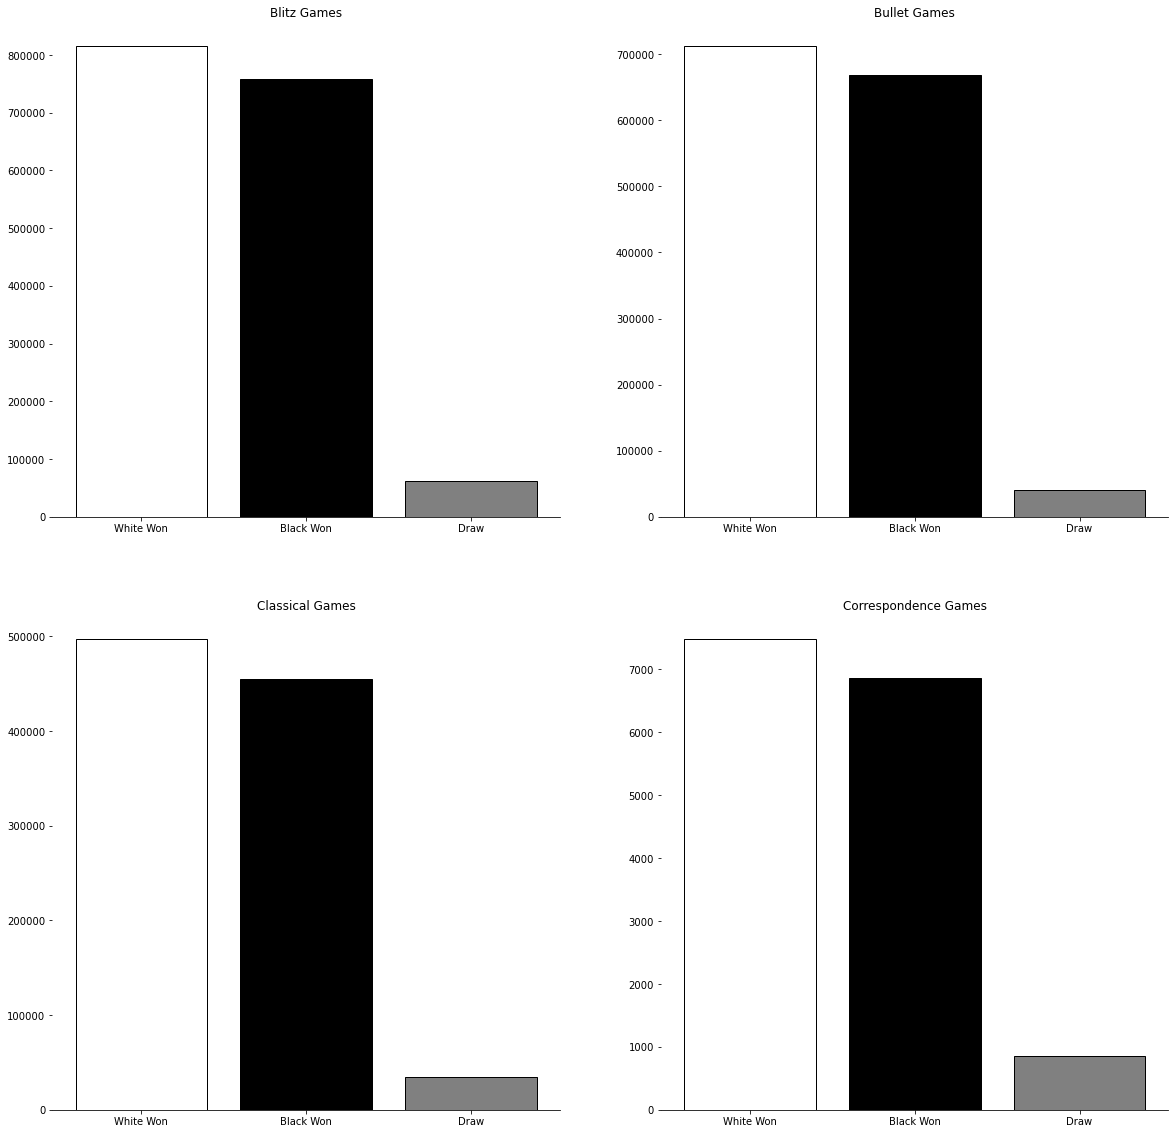

In [5]:
labels = np.array(["Blitz", "Bullet", "Classical", "Correspondence"])
whiteWon0 = len(data.loc[("1-0", labels[0])])
blackWon0 = len(data.loc[("0-1", labels[0])])
draw0 = len(data.loc[("1/2-1/2", labels[0])])
whiteWon1 = len(data.loc[("1-0", labels[1])])
blackWon1 = len(data.loc[("0-1", labels[1])])
draw1 = len(data.loc[("1/2-1/2", labels[1])])
whiteWon2 = len(data.loc[("1-0", labels[2])])
blackWon2 = len(data.loc[("0-1", labels[2])])
draw2 = len(data.loc[("1/2-1/2", labels[2])])
whiteWon3 = len(data.loc[("1-0", labels[3])])
blackWon3 = len(data.loc[("0-1", labels[3])])
draw3 = len(data.loc[("1/2-1/2", labels[3])])

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs[0, 0].bar("White Won", whiteWon0, color="white", edgecolor="black")
axs[0, 0].bar("Black Won", blackWon0, color="black", edgecolor="black")
axs[0, 0].bar("Draw", draw0, color="gray", edgecolor="black")
axs[0, 0].set_title("Blitz Games")
axs[0, 0].spines["top"].set_visible(False)
axs[0, 0].spines["right"].set_visible(False)
axs[0, 0].spines["left"].set_visible(False)

axs[0, 1].bar("White Won", whiteWon1, color="white", edgecolor="black")
axs[0, 1].bar("Black Won", blackWon1, color="black", edgecolor="black")
axs[0, 1].bar("Draw", draw1, color="gray", edgecolor="black")
axs[0, 1].set_title("Bullet Games")
axs[0, 1].spines["top"].set_visible(False)
axs[0, 1].spines["right"].set_visible(False)
axs[0, 1].spines["left"].set_visible(False)

axs[1, 0].bar("White Won", whiteWon2, color="white", edgecolor="black")
axs[1, 0].bar("Black Won", blackWon2, color="black", edgecolor="black")
axs[1, 0].bar("Draw", draw2, color="gray", edgecolor="black")
axs[1, 0].set_title("Classical Games")
axs[1, 0].spines["top"].set_visible(False)
axs[1, 0].spines["right"].set_visible(False)
axs[1, 0].spines["left"].set_visible(False)

axs[1, 1].bar("White Won", whiteWon3, color="white", edgecolor="black")
axs[1, 1].bar("Black Won", blackWon3, color="black", edgecolor="black")
axs[1, 1].bar("Draw", draw3, color="gray", edgecolor="black")
axs[1, 1].set_title("Correspondence Games")
axs[1, 1].spines["top"].set_visible(False)
axs[1, 1].spines["right"].set_visible(False)
axs[1, 1].spines["left"].set_visible(False)


From the looks of it, the first move advantage given to white becomes less exaggerated with looser time controls, as evidenced by the increased proportion of draws and black victories in the longer games like Classical and Correspondence. The total lack of time control may also allow players more time to think about their moves and come up with the best possible response to their opponent's play, hence the relatively large proportion of draws in Correspondence games.

Now let's look at players' ELO and the impact they have on the outcome of the game. We'll also include a kernel density approximation line to get a better idea of the trend of the density of the data.

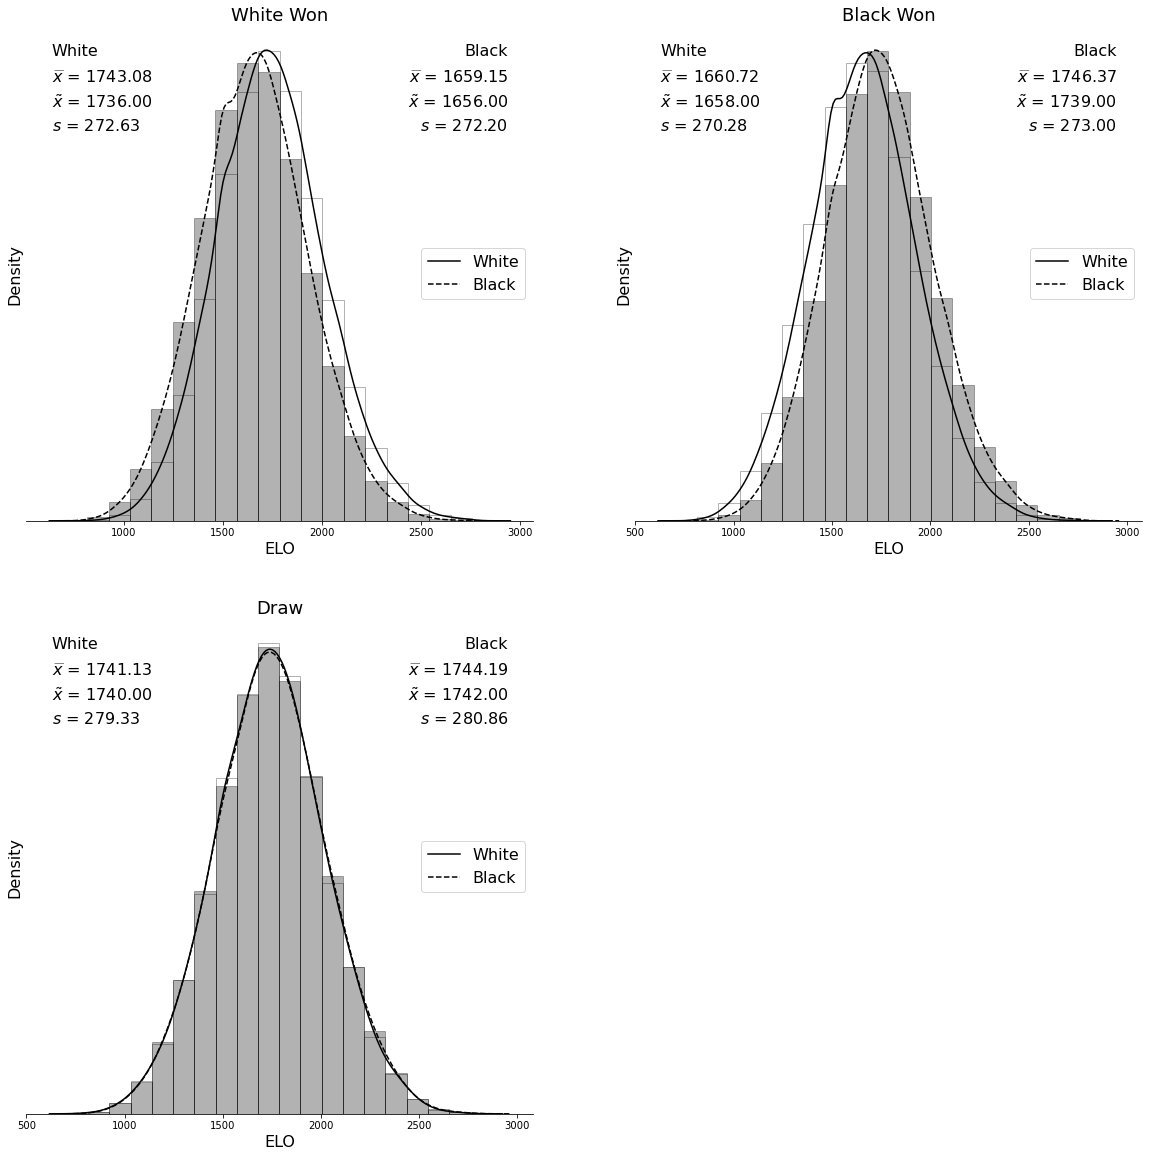

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
fig.delaxes(axs[1, 1])

# set the range so every histogram looks the same
# range is from absolute minimum ELO to absolute maximum, regardless of color
r = (
    min(np.min(data["White ELO"]), np.min(data["Black ELO"])),
    max(np.max(data["White ELO"]), np.max(data["Black ELO"])),
)

# draw histograms and overlay kernel density approximation lines
def draw_hist(ax1, ax2, result, color):
    axs[ax1, ax2].hist(
        data.loc[result][f"{color} ELO"],
        bins=20,
        range=r,
        density=True,
        color=color,
        edgecolor="black",
        alpha=0.3,
    )
    # if we're plotting the black data we need to differentiate the kde plot
    ls = "solid"
    if color == "Black":
        ls = "dashed"
    # kernel density estimation lines to aid visualizations
    sns.kdeplot(
        data=data.loc[result][["White ELO", "Black ELO"]].reset_index(),
        x=f"{color} ELO",
        bw_adjust=2,
        ax=axs[ax1, ax2],
        label=color,
        color="black",
        linestyle=ls,
    )


# add info to each plot, including mean, median, and standard deviation for each color
def add_info(ax1, ax2, result, title):
    # labels
    axs[ax1, ax2].set_title(title, fontsize=18)
    axs[ax1, ax2].set_xlabel("ELO", fontsize=16)
    axs[ax1, ax2].set_ylabel("Density", fontsize=16)

    # White stat information
    axs[ax1, ax2].text(
        0.05,
        0.95,
        "White",
        transform=axs[ax1, ax2].transAxes,
        horizontalalignment="left",
        verticalalignment="center",
        fontsize=16,
    )
    axs[ax1, ax2].text(
        0.05,
        0.9,
        f"$\widebar{{x}}$ = {np.mean(data.loc[result]['White ELO']):.2f}",
        transform=axs[ax1, ax2].transAxes,
        horizontalalignment="left",
        verticalalignment="center",
        fontsize=16,
    )
    axs[ax1, ax2].text(
        0.05,
        0.85,
        rf"$\tilde{{x}}$ = {np.median(data.loc[result]['White ELO']):.2f}",
        transform=axs[ax1, ax2].transAxes,
        horizontalalignment="left",
        verticalalignment="center",
        fontsize=16,
    )
    axs[ax1, ax2].text(
        0.05,
        0.8,
        f"$s$ = {np.std(data.loc[result]['White ELO']):.2f}",
        transform=axs[ax1, ax2].transAxes,
        horizontalalignment="left",
        verticalalignment="center",
        fontsize=16,
    )

    # Black stat information
    axs[ax1, ax2].text(
        0.95,
        0.95,
        "Black",
        transform=axs[ax1, ax2].transAxes,
        horizontalalignment="right",
        verticalalignment="center",
        fontsize=16,
    )
    axs[ax1, ax2].text(
        0.95,
        0.9,
        f"$\widebar{{x}}$ = {np.mean(data.loc[result]['Black ELO']):.2f}",
        transform=axs[ax1, ax2].transAxes,
        horizontalalignment="right",
        verticalalignment="center",
        fontsize=16,
    )
    axs[ax1, ax2].text(
        0.95,
        0.85,
        rf"$\tilde{{x}}$ = {np.median(data.loc[result]['Black ELO']):.2f}",
        transform=axs[ax1, ax2].transAxes,
        horizontalalignment="right",
        verticalalignment="center",
        fontsize=16,
    )
    axs[ax1, ax2].text(
        0.95,
        0.8,
        f"$s$ = {np.std(data.loc[result]['Black ELO']):.2f}",
        transform=axs[ax1, ax2].transAxes,
        horizontalalignment="right",
        verticalalignment="center",
        fontsize=16,
    )

    axs[ax1, ax2].legend(loc="center right", fontsize=16)
    axs[ax1, ax2].spines["top"].set_visible(False)
    axs[ax1, ax2].spines["right"].set_visible(False)
    axs[ax1, ax2].spines["left"].set_visible(False)
    axs[ax1, ax2].axes.yaxis.set_ticks([])


draw_hist(0, 0, "1-0", "White")
draw_hist(0, 0, "1-0", "Black")
draw_hist(0, 1, "0-1", "White")
draw_hist(0, 1, "0-1", "Black")
draw_hist(1, 0, "1/2-1/2", "White")
draw_hist(1, 0, "1/2-1/2", "Black")

add_info(0, 0, "1-0", "White Won")
add_info(0, 1, "0-1", "Black Won")
add_info(1, 0, "1/2-1/2", "Draw")


That's a little better. Now we see a clear deliniation between white winning and black winning, with white having a higher average ELO when white wins and vice versa when black wins. Draws are also almost perfectly even, with both distributions having nearly identical means, medians, and standard deviations. Interestingly, the ELO distributions for white wins and black wins are almost perfectly opposite, with the average white ELO for a white win being similar to the average black ELO for black wins.

Of course, this removes the paired nature of the data, as each game is played between two players, one black and one white. Let's add a column to our DataFrame that represents the ELO difference between the two players then analyze that difference in relation to wins to keep the pairedness of the data.

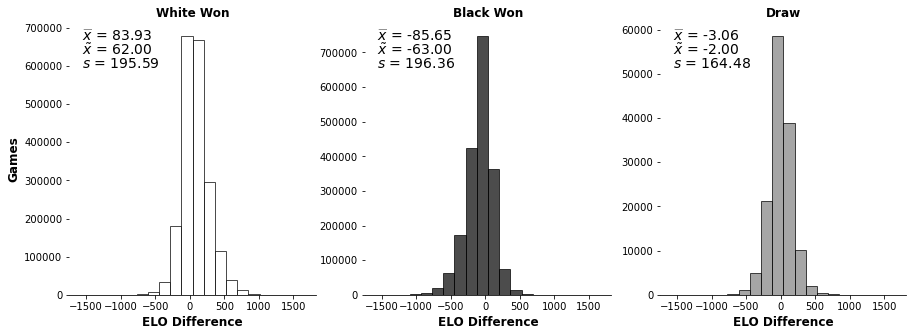

In [7]:
data["ELO Difference"] = (data["White ELO"] - data["Black ELO"]).astype("int16")
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
r = (np.min(data["ELO Difference"]), np.max(data["ELO Difference"]))

axs[0].hist(
    data.loc["1-0"]["ELO Difference"],
    bins=20,
    range=r,
    color="white",
    edgecolor="black",
    alpha=0.7,
)
axs[1].hist(
    data.loc["0-1"]["ELO Difference"],
    bins=20,
    range=r,
    color="black",
    edgecolor="black",
    alpha=0.7,
)
axs[2].hist(
    data.loc["1/2-1/2"]["ELO Difference"],
    bins=20,
    range=r,
    color="gray",
    edgecolor="black",
    alpha=0.7,
)


def add_info(pNum, result, title):
    axs[pNum].set_title(title, size="large", fontweight="bold")
    axs[pNum].set_xlabel("ELO Difference", size="large", fontweight="bold")
    axs[pNum].text(
        0.05,
        0.95,
        f"$\widebar{{x}}$ = {np.mean(data.loc[result]['ELO Difference']):.2f}",
        transform=axs[pNum].transAxes,
        horizontalalignment="left",
        verticalalignment="center",
        fontsize=14,
    )
    axs[pNum].text(
        0.05,
        0.9,
        rf"$\tilde{{x}}$ = {np.median(data.loc[result]['ELO Difference']):.2f}",
        transform=axs[pNum].transAxes,
        horizontalalignment="left",
        verticalalignment="center",
        fontsize=14,
    )
    axs[pNum].text(
        0.05,
        0.85,
        f"$s$ = {np.std(data.loc[result]['ELO Difference']):.2f}",
        transform=axs[pNum].transAxes,
        horizontalalignment="left",
        verticalalignment="center",
        fontsize=14,
    )
    axs[pNum].spines["top"].set_visible(False)
    axs[pNum].spines["right"].set_visible(False)
    axs[pNum].spines["left"].set_visible(False)


axs[0].set_ylabel("Games", size="large", fontweight="bold")
add_info(0, "1-0", "White Won")
add_info(1, "0-1", "Black Won")
add_info(2, "1/2-1/2", "Draw")


Perhaps unsurprisingly, we see the same trend as we did in the un-paired data, with white having a higher ELO when white wins and black having a higher ELO when black wins. Just like before, the white and black distributions appear to be near mirrors of each other while the draw distribution is almost perfectly Gaussian centered around 0.

Let's bring back that idea of different game types having an effect on game outcome, and this time include the ELO difference as well.

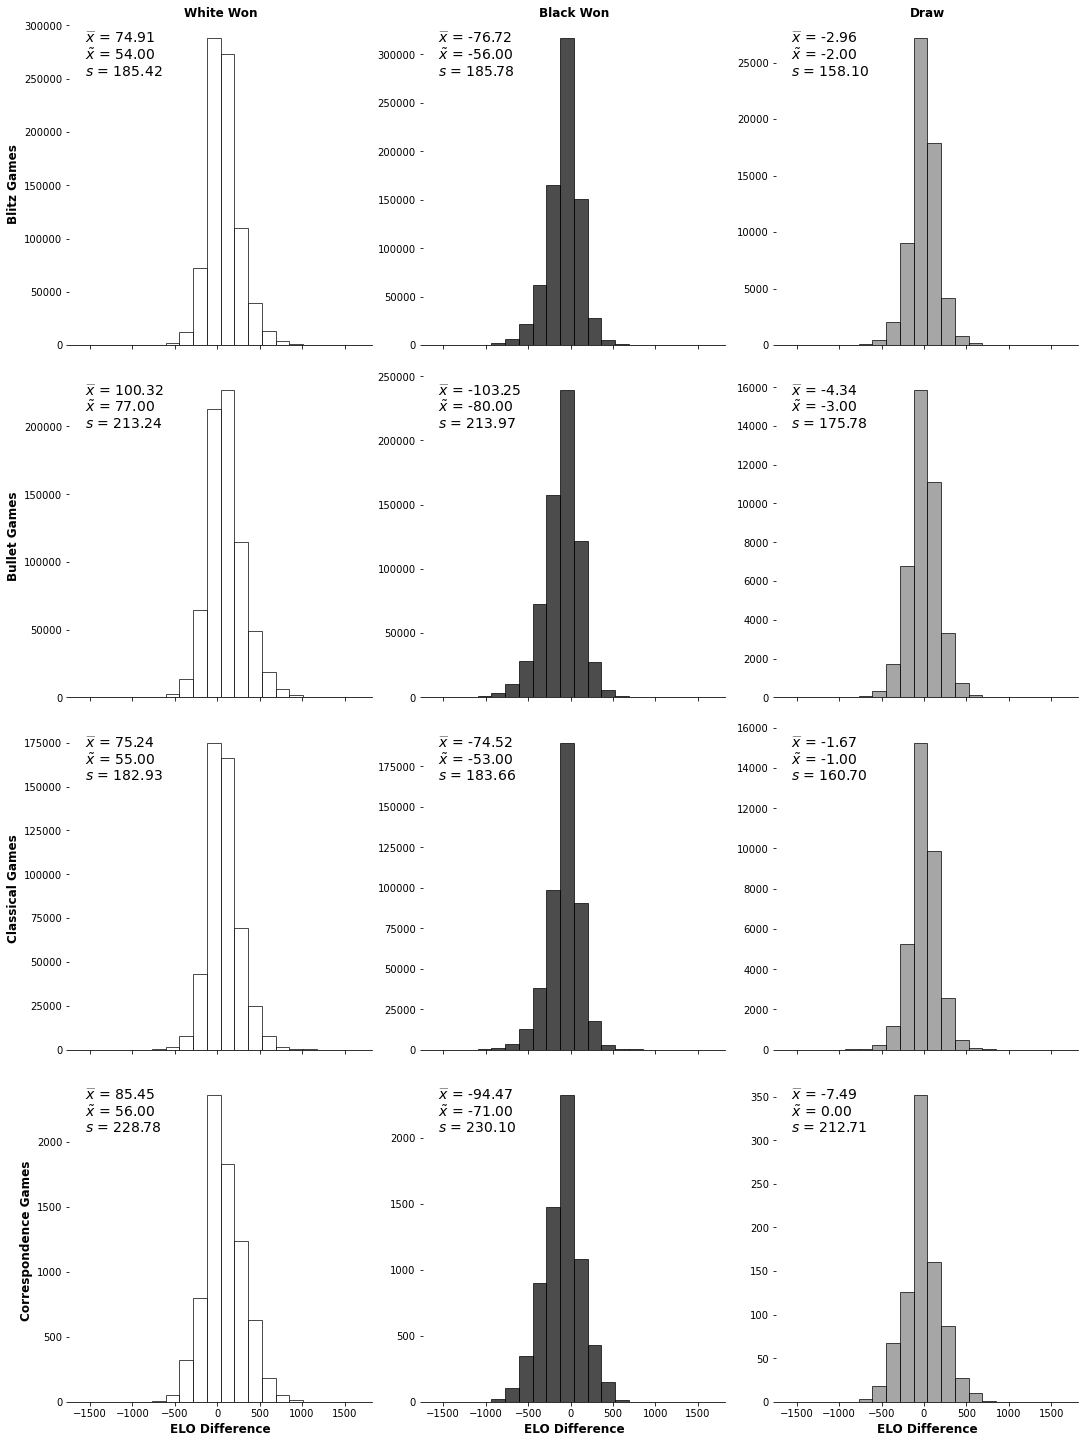

In [8]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20), sharex=True)
fig.tight_layout(pad=2)
gameTypes = ["Blitz", "Bullet", "Classical", "Correspondence"]
results = ["1-0", "0-1", "1/2-1/2"]
colors = ["white", "black", "gray"]
r = (np.min(data["ELO Difference"]), np.max(data["ELO Difference"]))

axs[0, 0].set_title("White Won", fontweight="bold", size="large")
axs[0, 1].set_title("Black Won", fontweight="bold", size="large")
axs[0, 2].set_title("Draw", fontweight="bold", size="large")
axs[0, 0].set_ylabel("Blitz Games", fontweight="bold", size="large")
axs[1, 0].set_ylabel("Bullet Games", fontweight="bold", size="large")
axs[2, 0].set_ylabel("Classical Games", fontweight="bold", size="large")
axs[3, 0].set_ylabel("Correspondence Games", fontweight="bold", size="large")
axs[3, 0].set_xlabel("ELO Difference", fontweight="bold", size="large")
axs[3, 1].set_xlabel("ELO Difference", fontweight="bold", size="large")
axs[3, 2].set_xlabel("ELO Difference", fontweight="bold", size="large")

for i in range(4):
    for j in range(3):
        axs[i, j].hist(
            data.loc[results[j], gameTypes[i]]["ELO Difference"],
            bins=20,
            range=r,
            color=colors[j],
            edgecolor="black",
            alpha=0.7,
        )
        axs[i, j].text(
            0.05,
            0.95,
            f"$\widebar{{x}}$ = {np.mean(data.loc[results[j], gameTypes[i]]['ELO Difference']):.2f}",
            transform=axs[i, j].transAxes,
            horizontalalignment="left",
            verticalalignment="center",
            fontsize=14,
        )
        axs[i, j].text(
            0.05,
            0.9,
            rf"$\tilde{{x}}$ = {np.median(data.loc[results[j], gameTypes[i]]['ELO Difference']):.2f}",
            transform=axs[i, j].transAxes,
            horizontalalignment="left",
            verticalalignment="center",
            fontsize=14,
        )
        axs[i, j].text(
            0.05,
            0.85,
            f"$s$ = {np.std(data.loc[results[j], gameTypes[i]]['ELO Difference']):.2f}",
            transform=axs[i, j].transAxes,
            horizontalalignment="left",
            verticalalignment="center",
            fontsize=14,
        )
        axs[i, j].spines["top"].set_visible(False)
        axs[i, j].spines["right"].set_visible(False)
        axs[i, j].spines["left"].set_visible(False)


As we saw before, all game types follow the same general trend and our black and white distributions are essentially mirrors of each other while the draw distribution is almost Gaussian.

Let's take a look at the number of moves per game to see if we can maybe draw some sort of inference there.

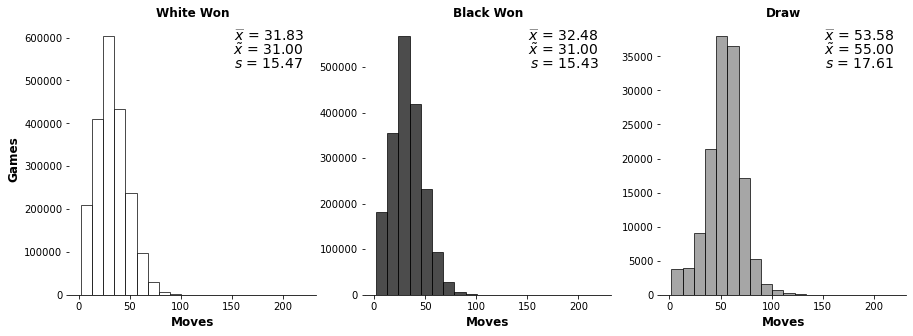

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
r = (np.min(data["Moves"]), np.max(data["Moves"]))

axs[0].hist(
    data.loc["1-0"]["Moves"],
    bins=20,
    range=r,
    color="white",
    edgecolor="black",
    alpha=0.7,
)
axs[1].hist(
    data.loc["0-1"]["Moves"],
    bins=20,
    range=r,
    color="black",
    edgecolor="black",
    alpha=0.7,
)
axs[2].hist(
    data.loc["1/2-1/2"]["Moves"],
    bins=20,
    range=r,
    color="gray",
    edgecolor="black",
    alpha=0.7,
)


def add_info(pNum, result, title):
    axs[pNum].set_title(title, size="large", fontweight="bold")
    axs[pNum].set_xlabel("Moves", size="large", fontweight="bold")
    axs[pNum].text(
        0.95,
        0.95,
        f"$\widebar{{x}}$ = {np.mean(data.loc[result]['Moves']):.2f}",
        transform=axs[pNum].transAxes,
        horizontalalignment="right",
        verticalalignment="center",
        fontsize=14,
    )
    axs[pNum].text(
        0.95,
        0.9,
        rf"$\tilde{{x}}$ = {np.median(data.loc[result]['Moves']):.2f}",
        transform=axs[pNum].transAxes,
        horizontalalignment="right",
        verticalalignment="center",
        fontsize=14,
    )
    axs[pNum].text(
        0.95,
        0.85,
        f"$s$ = {np.std(data.loc[result]['Moves']):.2f}",
        transform=axs[pNum].transAxes,
        horizontalalignment="right",
        verticalalignment="center",
        fontsize=14,
    )
    axs[pNum].spines["top"].set_visible(False)
    axs[pNum].spines["right"].set_visible(False)
    axs[pNum].spines["left"].set_visible(False)


axs[0].set_ylabel("Games", size="large", fontweight="bold")
add_info(0, "1-0", "White Won")
add_info(1, "0-1", "Black Won")
add_info(2, "1/2-1/2", "Draw")


This visualization of move numbers helps us to deliniate the draws from the victories, but white winning and black winning are nearly indistinguishable from each other.

What if we plot the ELO difference against the number of moves, maybe higher ELO difference games end quicker because one player is clearly better than the other?

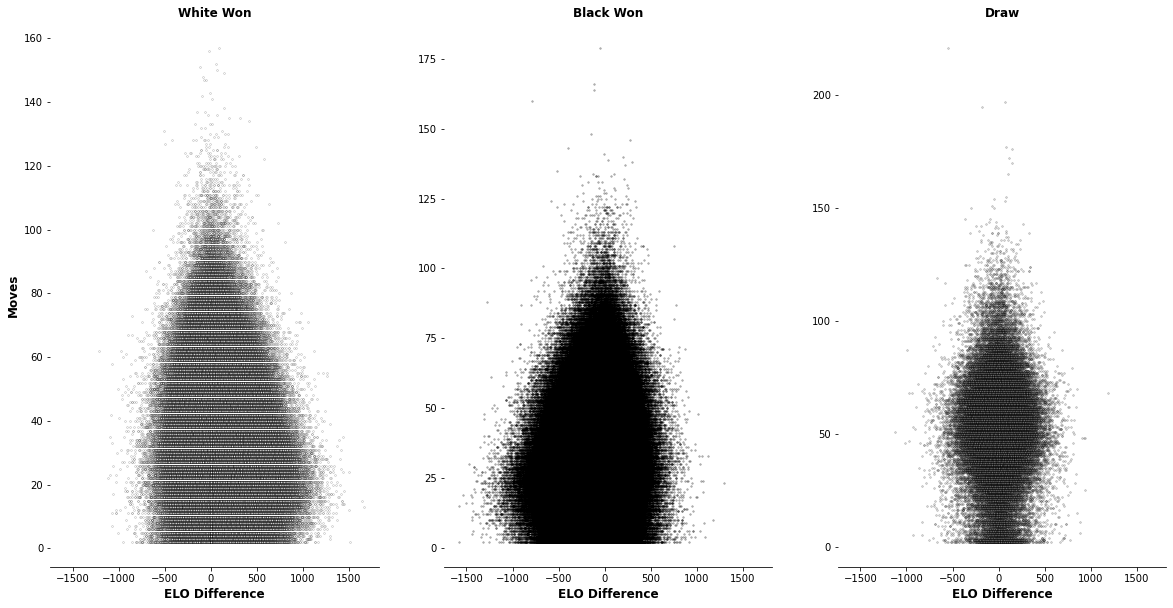

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10), sharex=True)

axs[0].set_title("White Won", fontweight="bold", size="large")
axs[0].set_xlabel("ELO Difference", fontweight="bold", size="large")
axs[1].set_title("Black Won", fontweight="bold", size="large")
axs[1].set_xlabel("ELO Difference", fontweight="bold", size="large")
axs[2].set_title("Draw", fontweight="bold", size="large")
axs[2].set_xlabel("ELO Difference", fontweight="bold", size="large")
axs[0].set_ylabel("Moves", fontweight="bold", size="large")

axs[0].scatter(
    data.loc["1-0"]["ELO Difference"],
    data.loc["1-0"]["Moves"],
    c="white",
    edgecolors="black",
    alpha=0.3,
    linewidth=0.5,
    s=3,
)
axs[1].scatter(
    data.loc["0-1"]["ELO Difference"],
    data.loc["0-1"]["Moves"],
    c="black",
    edgecolors="black",
    alpha=0.3,
    linewidth=0.5,
    s=3,
)
axs[2].scatter(
    data.loc["1/2-1/2"]["ELO Difference"],
    data.loc["1/2-1/2"]["Moves"],
    c="gray",
    edgecolors="black",
    alpha=0.3,
    linewidth=0.5,
    s=3,
)
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["left"].set_visible(False)
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["left"].set_visible(False)
axs[2].spines["top"].set_visible(False)
axs[2].spines["right"].set_visible(False)
axs[2].spines["left"].set_visible(False)


As predicted, the games with the largest ELO difference are ending sooner than those with less ELO difference, and the draws are still taking the longest.

All told, the clearest predictor of who will win any given game is the ELO of each player, more specifically the difference between the ELOs of each player. If we want to minimize the effect that white's first move advantage has on the game, even the scales so to say, the best way to go about this would be to allow the black blayer to have a slightly higher ELO than the white player. The advantage white gains from being able to move first will hopfully offset the disadvantage white gains from being lower ranked.